<a href="https://colab.research.google.com/github/armughan03/MSDS19042_COVID19_DLSpring2020/blob/master/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

In [0]:
# !unzip '/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/A_05_Part_02_Dataset.zip'

# Load Dataset using torchvision image loader

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'

In [5]:
!mkdir /content/A_05_Part_02_Dataset/normal/
!mkdir /content/A_05_Part_02_Dataset/Test/normal/

mkdir: cannot create directory ‘/content/A_05_Part_02_Dataset/Test/normal/’: File exists


In [0]:
!mv  /content/A_05_Part_02_Dataset/Test/* /content/A_05_Part_02_Dataset/normal/
!mv /content/A_05_Part_02_Dataset/normal/ /content/A_05_Part_02_Dataset/Test/normal/

In [0]:
!rm -rf /content/A_05_Part_02_Dataset/normal/

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test/', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


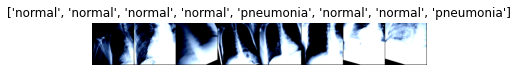

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Loading pretrained CNN models and fine-tuning the FC Layers Without Focal Loss


# RESNET 18

In [94]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of RESNET18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Finetuning FC Layer

In [0]:
# Removing last layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential()

### Adding new Layers

In [0]:
fc = nn.Linear(num_features,len(class_names))

In [97]:
resnet18.fc = fc
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training & Validation

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.005, momentum=0.9)

In [99]:
from tqdm import tqdm
from tqdm import tqdm_notebook

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
valid_loss = []
loss_per_epoch = []
train_accuracy_per_epoch = []
valid_accuracy_per_epoch = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    loss_history = []
    accuracy = []
    correct = 0
    total = 0
    running_loss = 0.0

    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels,num_classes=3)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        labels_hot = labels_hot.type_as(outputs)        
        loss = criterion(outputs, labels_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        loss_history.append(loss.data)
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.nelement()
        correct += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct / total
        accuracy.append(train_accuracy)
    correct = 0
    total = 0
    nb_classes = 2

    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels_hot = nn.functional.one_hot(labels,num_classes=3)
            outputs = resnet18(images)
            labels_hot = labels_hot.type_as(outputs)
            loss = criterion(outputs, labels_hot)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
    valid_accuracy = correct / total * 100
    print('Accuracy of the network on the validation images: %d %%' % (
        valid_accuracy))
    loss_per_epoch.append(sum(loss_history)/len(loss_history))
    train_accuracy_per_epoch.append(sum(accuracy)/len(accuracy))
    valid_accuracy_per_epoch.append(valid_accuracy)
    valid_loss.append(loss.data)
    torch.save(resnet18.state_dict(), 'resnet18_without_focal_loss.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy of the network on the validation images: 87 %



Accuracy of the network on the validation images: 87 %



Accuracy of the network on the validation images: 88 %



Accuracy of the network on the validation images: 90 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 91 %



Accuracy of the network on the validation images: 91 %



Accuracy of the network on the validation images: 94 %



Accuracy of the network on the validation images: 93 %



Accuracy of the network on the validation images: 94 %
Finished Training


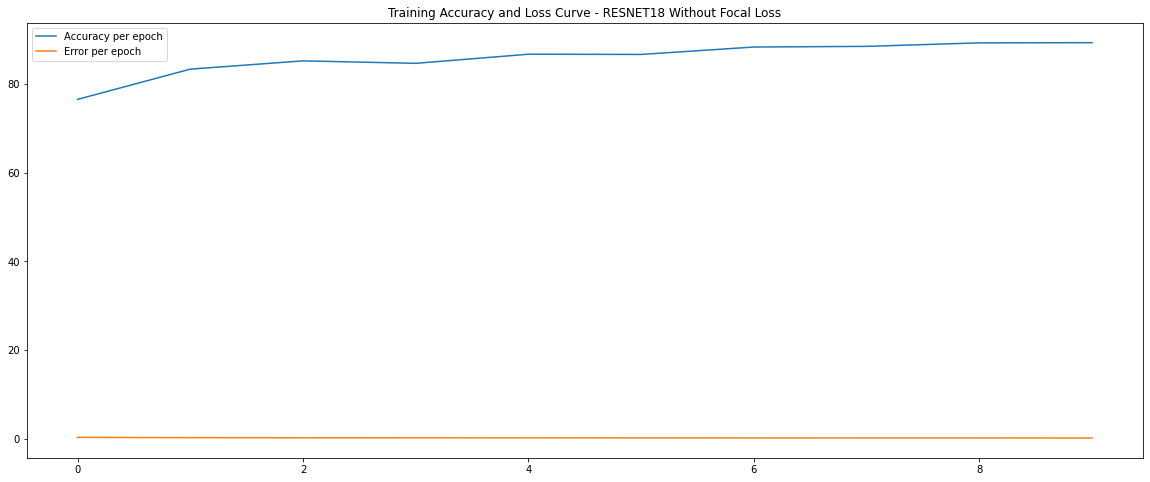

In [100]:
plt.figure(figsize=(20,8))
plt.plot(train_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(loss_per_epoch,label = "Error per epoch")
plt.title('Training Accuracy and Loss Curve - RESNET18 Without Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

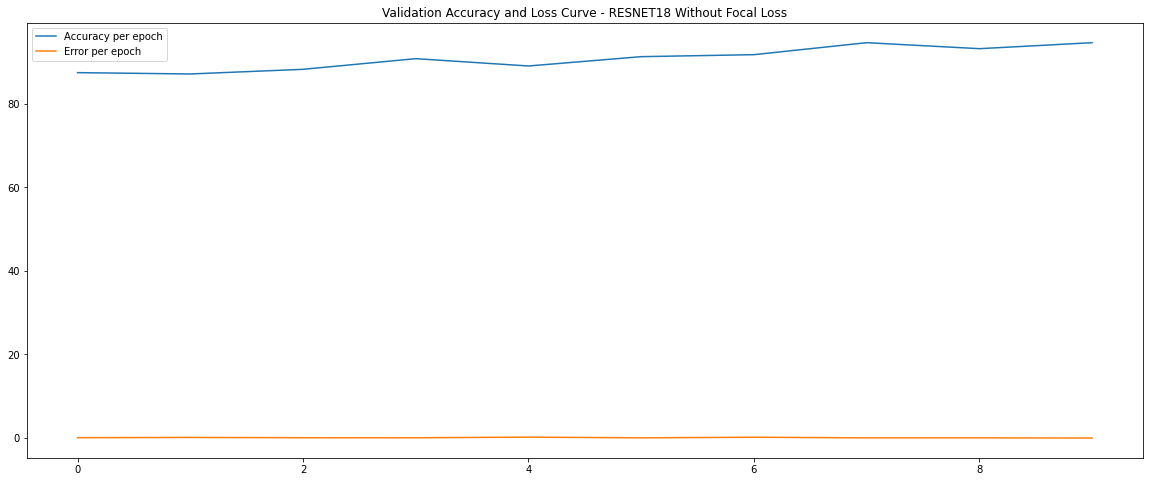

In [101]:
plt.figure(figsize=(20,8))
plt.plot(valid_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(valid_loss,label = "Error per epoch")
plt.title('Validation Accuracy and Loss Curve - RESNET18 Without Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [102]:
correct = 0
total = 0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = resnet18(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = labels
        y_pred = predicted
training_accuracy = correct / total * 100
print('Accuracy of the network on the training images: %d %%' % (
        training_accuracy))

Accuracy of the network on the training images: 90 %


In [103]:
from sklearn.metrics import multilabel_confusion_matrix
train_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
train_confusion_matrix = train_conf_mat
print('Train Confusion Matrix',train_confusion_matrix)

Train Confusion Matrix [[[5984   16]
  [ 110   90]]

 [[1828  372]
  [ 118 3882]]

 [[4018  182]
  [ 342 1658]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


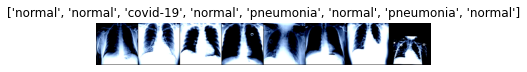

In [104]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [105]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal pneumonia normal pneumonia pneumonia
Ground Truth:  normal normal covid-19 normal pneumonia normal pneumonia normal


In [106]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = resnet18(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 94 %


In [107]:
from sklearn.metrics import multilabel_confusion_matrix
valid_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
validation_confusion_matrix = valid_conf_mat
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[[600   0]
  [ 10  18]]

 [[202  26]
  [  6 394]]

 [[420   8]
  [ 18 182]]]


In [0]:
!cp '/content/resnet18_without_focal_loss.pth' '/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/'

## Testing Data Labeling

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# show_databatch(images, labels)  

#### Getting Images Names

In [112]:
import glob
names = [os.path.basename(x) for x in glob.glob('/content/A_05_Part_02_Dataset/Test/normal/*')]
len(names)

629

In [0]:
# label predictions
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
          pred.append(predicted[i])

In [0]:
# labels to numpy
label = [pred[i].cpu().numpy() for i in range(len(pred))]
label = np.array(label)

In [0]:
# one hot encoding
label_one_hot = np.zeros((label.size, label.max()+1))
label_one_hot[np.arange(label.size),label] = 1

In [0]:
# separating the labels
covid = [int(label_one_hot[i][0]) for i in range(len(label_one_hot))]
normal = [int(label_one_hot[i][1]) for i in range(len(label_one_hot))]
pneumonia = [int(label_one_hot[i][2]) for i in range(len(label_one_hot))]

In [0]:
predicted_dataframe = pd.DataFrame({'0':names,'1':covid,'2':pneumonia,'3':normal})

In [118]:
predicted_dataframe.head()

,0,1,2,3
0,570.png,0,0,1
1,17.png,0,0,1
2,362.png,0,0,1
3,147.png,0,1,0
4,583.png,0,0,1


In [0]:
predicted_dataframe.to_csv('/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/RESNET18_Without_FocalLoss.csv')

# VGG16

In [149]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Finetuning FC Layer

In [150]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


### Adding new Layers

In [151]:
features.extend([nn.Linear(num_features, 3)])
features

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=3, bias=True)]

In [152]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training & Validation

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

In [154]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
valid_loss = []
loss_per_epoch = []
train_accuracy_per_epoch = []
valid_accuracy_per_epoch = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    loss_history = []
    accuracy = []
    correct = 0
    total = 0
    running_loss = 0.0

    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels,num_classes=3)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        labels_hot = labels_hot.type_as(outputs)        
        loss = criterion(outputs, labels_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        loss_history.append(loss.data)
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.nelement()
        correct += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct / total
        accuracy.append(train_accuracy)
    correct = 0
    total = 0
    nb_classes = 2

    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels_hot = nn.functional.one_hot(labels,num_classes=3)
            outputs = vgg16(images)
            labels_hot = labels_hot.type_as(outputs)
            loss = criterion(outputs, labels_hot)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
    valid_accuracy = correct / total * 100
    print('Accuracy of the network on the validation images: %d %%' % (
        valid_accuracy))
    loss_per_epoch.append(sum(loss_history)/len(loss_history))
    train_accuracy_per_epoch.append(sum(accuracy)/len(accuracy))
    valid_accuracy_per_epoch.append(valid_accuracy)
    valid_loss.append(loss.data)
    torch.save(vgg16.state_dict(), 'vgg16_without_focal_loss.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy of the network on the validation images: 83 %



Accuracy of the network on the validation images: 83 %



Accuracy of the network on the validation images: 87 %



Accuracy of the network on the validation images: 92 %



Accuracy of the network on the validation images: 90 %



Accuracy of the network on the validation images: 91 %



Accuracy of the network on the validation images: 92 %



Accuracy of the network on the validation images: 87 %



Accuracy of the network on the validation images: 91 %



Accuracy of the network on the validation images: 92 %
Finished Training


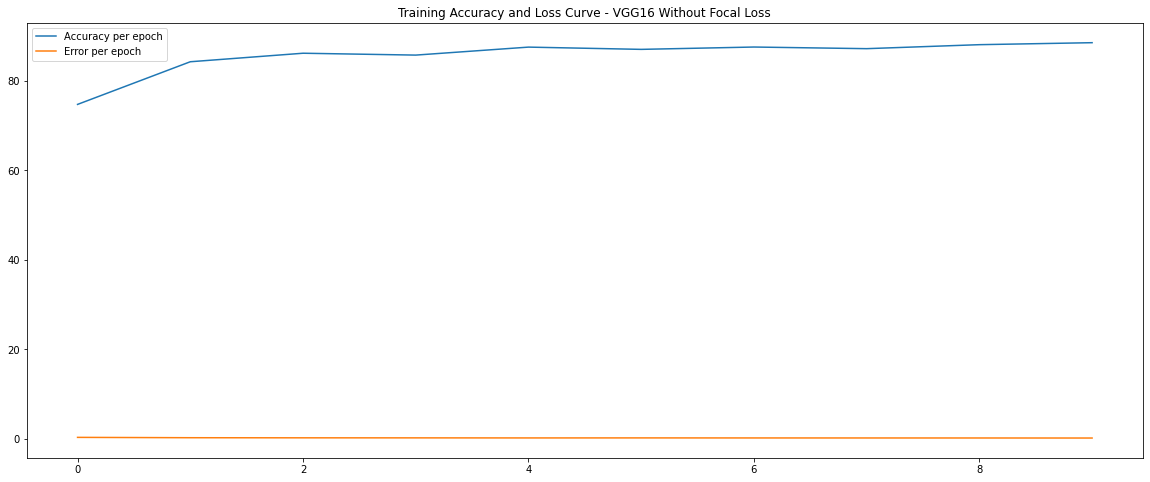

In [155]:
plt.figure(figsize=(20,8))
plt.plot(train_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(loss_per_epoch,label = "Error per epoch")
plt.title('Training Accuracy and Loss Curve - VGG16 Without Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

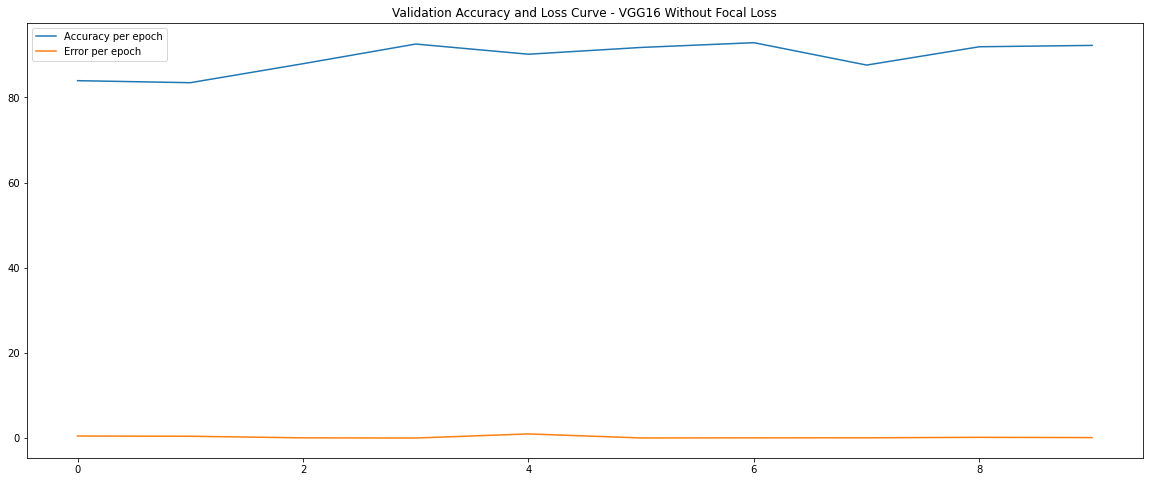

In [156]:
plt.figure(figsize=(20,8))
plt.plot(valid_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(valid_loss,label = "Error per epoch")
plt.title('Validation Accuracy and Loss Curve - VGG16 Without Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [157]:
correct = 0
total = 0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = vgg16(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = labels
        y_pred = predicted
training_accuracy = correct / total * 100
print('Accuracy of the network on the training images: %d %%' % (
        training_accuracy))

Accuracy of the network on the training images: 88 %


In [158]:
from sklearn.metrics import multilabel_confusion_matrix
train_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
train_confusion_matrix = train_conf_mat
print('Train Confusion Matrix',train_confusion_matrix)

Train Confusion Matrix [[[5989   11]
  [ 158   42]]

 [[1678  522]
  [  87 3913]]

 [[4042  158]
  [ 446 1554]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


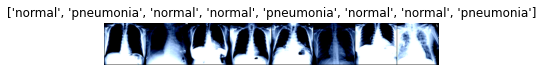

In [159]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [160]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal pneumonia normal normal pneumonia normal normal pneumonia
Ground Truth:  normal pneumonia normal normal pneumonia normal normal pneumonia


In [161]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = vgg16(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 92 %


In [162]:
from sklearn.metrics import multilabel_confusion_matrix
valid_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
validation_confusion_matrix = valid_conf_mat
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[[599   1]
  [ 21   7]]

 [[194  34]
  [  5 395]]

 [[415  13]
  [ 22 178]]]


In [0]:
# !cp '/content/vgg16_without_focal_loss.pth' '/content/drive/My Drive/Deep Learning/Assignment 5 Part 2'

## Testing Data Labeling

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# show_databatch(images, labels)  

#### Getting Images Names

In [163]:
import glob
names = [os.path.basename(x) for x in glob.glob('/content/A_05_Part_02_Dataset/Test/normal/*')]
len(names)

629

In [0]:
# label predictions
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
          pred.append(predicted[i])

In [0]:
# labels to numpy
label = [pred[i].cpu().numpy() for i in range(len(pred))]
label = np.array(label)

In [0]:
# one hot encoding
label_one_hot = np.zeros((label.size, label.max()+1))
label_one_hot[np.arange(label.size),label] = 1

In [0]:
# separating the labels
covid = [int(label_one_hot[i][0]) for i in range(len(label_one_hot))]
normal = [int(label_one_hot[i][1]) for i in range(len(label_one_hot))]
pneumonia = [int(label_one_hot[i][2]) for i in range(len(label_one_hot))]

In [0]:
predicted_dataframe_vgg16_without_focal = pd.DataFrame({'0':names,'1':covid,'2':pneumonia,'3':normal})

In [169]:
predicted_dataframe_vgg16_without_focal.head()

,0,1,2,3
0,570.png,0,0,1
1,17.png,0,0,1
2,362.png,0,0,1
3,147.png,0,1,0
4,583.png,0,0,1


In [0]:
predicted_dataframe_vgg16_without_focal.to_csv('/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/VGG16_Predicted_Without_FocalLoss.csv')

# Loading pretrained CNN models and fine-tuning the FC Layers With Focal Loss

# RESNET 18

In [124]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of RESNET18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Finetuning Layer

In [0]:
# Removing last layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential()

### Adding new Layers

In [0]:
fc = nn.Linear(num_features,len(class_names))


In [127]:
resnet18.fc = fc
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Focal Loss

In [0]:
class Focal_Loss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            bce_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-bce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Training & Validation

In [0]:
Epochs = 10
criterion = Focal_Loss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [130]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
valid_loss = []
loss_per_epoch = []
train_accuracy_per_epoch = []
valid_accuracy_per_epoch = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    loss_history = []
    accuracy = []
    correct = 0
    total = 0
    running_loss = 0.0

    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_one_hot = F.one_hot(labels,num_classes=len(class_names))
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        labels_one_hot = labels_one_hot.type_as(outputs)
        loss = criterion(outputs, labels_one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        loss_history.append(loss.data)
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.nelement()
        correct += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct / total
        accuracy.append(train_accuracy)
    correct = 0
    total = 0
    nb_classes = 2

    # Initialize the prediction and label lists(tensors)
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels,num_classes=len(class_names))
            outputs = resnet18(images)
            labels_one_hot = labels_one_hot.type_as(outputs)
            loss = criterion(outputs, labels_one_hot)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_accuracy = correct / total * 100
    print('Accuracy of the network on the validation images: %d %%' % (
        valid_accuracy))
    loss_per_epoch.append(sum(loss_history)/1500)
    train_accuracy_per_epoch.append(sum(accuracy)/1500)
    valid_accuracy_per_epoch.append(valid_accuracy)
    valid_loss.append(loss.data)
    torch.save(resnet18.state_dict(), 'resnet18_focal_loss.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Accuracy of the network on the validation images: 84 %



Accuracy of the network on the validation images: 85 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 87 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 86 %



Accuracy of the network on the validation images: 90 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 90 %
Finished Training


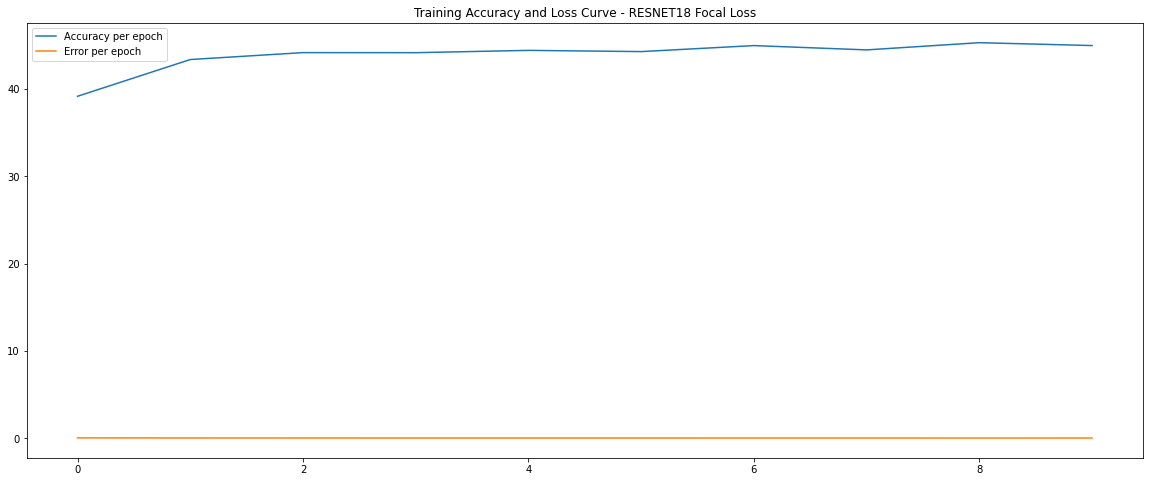

In [131]:
plt.figure(figsize=(20,8))
plt.plot(train_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(loss_per_epoch,label = "Error per epoch")
plt.title('Training Accuracy and Loss Curve - RESNET18 Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

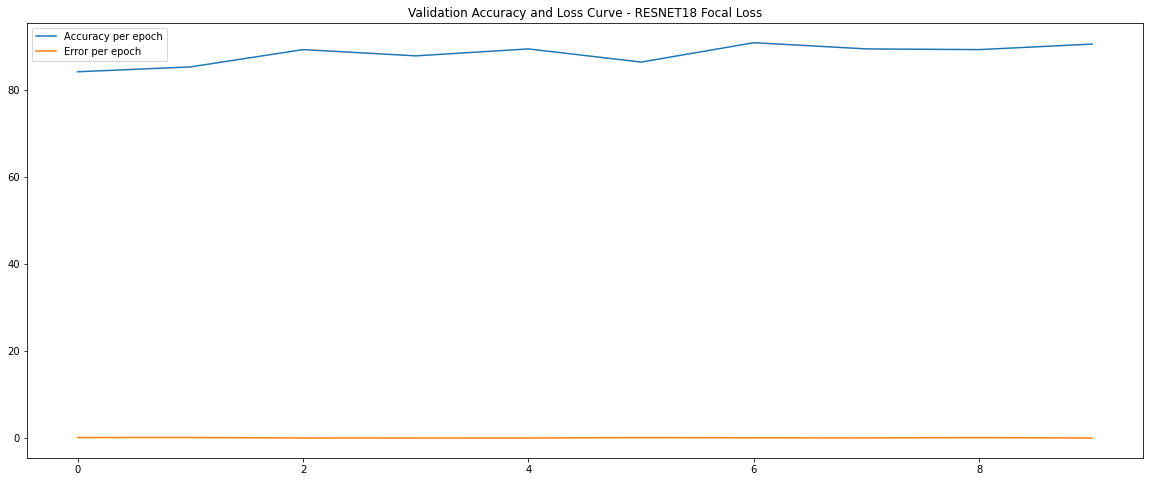

In [132]:
plt.figure(figsize=(20,8))
plt.plot(valid_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(valid_loss,label = "Error per epoch")
plt.title('Validation Accuracy and Loss Curve - RESNET18 Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [134]:
correct = 0
total = 0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = resnet18(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = labels
        y_pred = predicted
training_accuracy = correct / total * 100
print('Accuracy of the network on the training images: %d %%' % (
        training_accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Accuracy of the network on the training images: 87 %


In [135]:
from sklearn.metrics import multilabel_confusion_matrix
train_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
train_confusion_matrix = train_conf_mat
print('Train Confusion Matrix',train_confusion_matrix)

Train Confusion Matrix [[[5986   14]
  [ 136   64]]

 [[1800  400]
  [ 269 3731]]

 [[3850  350]
  [ 359 1641]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


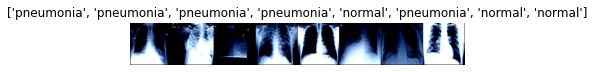

In [136]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [137]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  pneumonia pneumonia pneumonia pneumonia normal pneumonia normal normal
Ground Truth:  pneumonia pneumonia pneumonia pneumonia normal pneumonia normal normal


In [138]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = resnet18(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Accuracy of the network on the validation images: 89 %


In [139]:
from sklearn.metrics import multilabel_confusion_matrix
valid_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
validation_confusion_matrix = valid_conf_mat
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[[600   0]
  [ 16  12]]

 [[186  42]
  [ 19 381]]

 [[406  22]
  [ 29 171]]]


In [0]:
!cp '/content/resnet18_focal_loss.pth' '/content/drive/My Drive/Deep Learning/Assignment 5 Part 2'

## Testing Data Labeling

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# show_databatch(images, labels)  

#### Getting Images Names

In [141]:
import glob
names = [os.path.basename(x) for x in glob.glob('/content/A_05_Part_02_Dataset/Test/normal/*')]
len(names)

629

In [0]:
# label predictions
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
          pred.append(predicted[i])

In [0]:
# labels to numpy
label = [pred[i].cpu().numpy() for i in range(len(pred))]
label = np.array(label)

In [0]:
# one hot encoding
label_one_hot = np.zeros((label.size, label.max()+1))
label_one_hot[np.arange(label.size),label] = 1

In [0]:
# separating the labels
covid = [int(label_one_hot[i][0]) for i in range(len(label_one_hot))]
normal = [int(label_one_hot[i][1]) for i in range(len(label_one_hot))]
pneumonia = [int(label_one_hot[i][2]) for i in range(len(label_one_hot))]

In [0]:
predicted_dataframe_resnet_focal_loss = pd.DataFrame({'0':names,'1':covid,'2':pneumonia,'3':normal})

In [147]:
predicted_dataframe_resnet_focal_loss.head()

,0,1,2,3
0,570.png,0,0,1
1,17.png,0,0,1
2,362.png,0,0,1
3,147.png,0,1,0
4,583.png,0,0,1


In [0]:
predicted_dataframe_resnet_focal_loss.to_csv('/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/RESNET18_FocalLoss.csv')

# VGG 16

In [71]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Finetuning Layer

In [72]:
# Removing last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


### Adding new Layers

In [73]:
features.extend([nn.Linear(num_features, 42*100+100)])
features.extend([nn.Linear(42*100+100, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Focal Loss

In [0]:
class Focal_Loss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            bce_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-bce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Training & Validation

In [0]:
Epochs = 10
criterion = Focal_Loss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [76]:
from tqdm import tqdm
from tqdm import tqdm_notebook

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
valid_loss = []
loss_per_epoch = []
train_accuracy_per_epoch = []
valid_accuracy_per_epoch = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    loss_history = []
    accuracy = []
    correct = 0
    total = 0
    running_loss = 0.0

    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_one_hot = F.one_hot(labels,num_classes=len(class_names))
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        labels_one_hot = labels_one_hot.type_as(outputs)
        loss = criterion(outputs, labels_one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        # print statistics
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        loss_history.append(loss.data)
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.nelement()
        correct += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct / total
        accuracy.append(train_accuracy)
    correct = 0
    total = 0
    nb_classes = 2

    # Initialize the prediction and label lists(tensors)
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels,num_classes=len(class_names))
            outputs = vgg16(images)
            labels_one_hot = labels_one_hot.type_as(outputs)
            loss = criterion(outputs, labels_one_hot)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_accuracy = correct / total * 100
    print('Accuracy of the network on the validation images: %d %%' % (
        valid_accuracy))
    loss_per_epoch.append(sum(loss_history)/1500)
    train_accuracy_per_epoch.append(sum(accuracy)/1500)
    valid_accuracy_per_epoch.append(valid_accuracy)
    valid_loss.append(loss.data)
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 90 %



Accuracy of the network on the validation images: 91 %



Accuracy of the network on the validation images: 90 %



Accuracy of the network on the validation images: 92 %



Accuracy of the network on the validation images: 92 %



Accuracy of the network on the validation images: 92 %



Accuracy of the network on the validation images: 89 %



Accuracy of the network on the validation images: 93 %
Finished Training


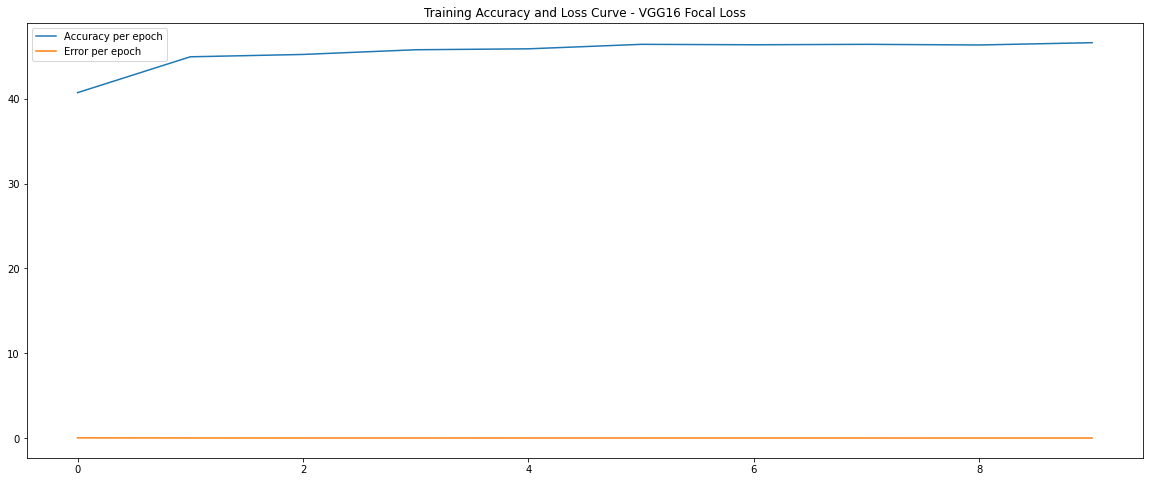

In [77]:
plt.figure(figsize=(20,8))
plt.plot(train_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(loss_per_epoch,label = "Error per epoch")
plt.title('Training Accuracy and Loss Curve - VGG16 Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.

plt.show()

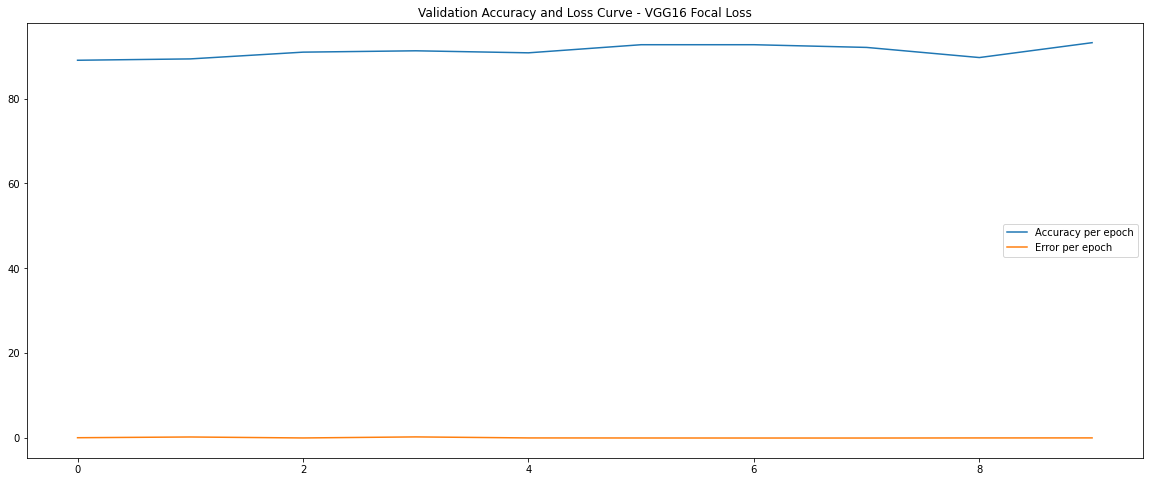

In [78]:
plt.figure(figsize=(20,8))
plt.plot(valid_accuracy_per_epoch,label = "Accuracy per epoch")
plt.plot(valid_loss,label = "Error per epoch")
plt.title('Validation Accuracy and Loss Curve - VGG16 Focal Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [79]:
correct = 0
total = 0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = vgg16(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = labels
        y_pred = predicted
training_accuracy = correct / total * 100
print('Accuracy of the network on the training images: %d %%' % (
        training_accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Accuracy of the network on the training images: 90 %


In [80]:
from sklearn.metrics import multilabel_confusion_matrix
train_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
train_confusion_matrix = train_conf_mat
print('Train Confusion Matrix',train_confusion_matrix)

Train Confusion Matrix [[[5973   27]
  [ 109   91]]

 [[1774  426]
  [  78 3922]]

 [[4075  125]
  [ 391 1609]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


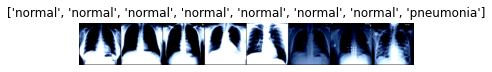

In [81]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [82]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal pneumonia
Ground Truth:  normal normal normal normal normal normal normal pneumonia


In [83]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels_hot = nn.functional.one_hot(labels, num_classes = len(class_names))
        outputs = vgg16(images)
        labels_hot = labels_hot.type_as(outputs)
        loss = criterion(outputs, labels_hot)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Accuracy of the network on the validation images: 93 %


In [84]:
from sklearn.metrics import multilabel_confusion_matrix
valid_conf_mat=multilabel_confusion_matrix(lbllist.numpy(), predlist.numpy())
validation_confusion_matrix = valid_conf_mat
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[[598   2]
  [ 16  12]]

 [[194  34]
  [  5 395]]

 [[421   7]
  [ 22 178]]]


In [0]:
!cp '/content/vgg16_focal_loss.pth' '/content/drive/My Drive/Deep Learning/Assignment 5 Part 2'

## Testing Data Labeling

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# show_databatch(images, labels)  

#### Getting Images Names

In [87]:
import glob
names = [os.path.basename(x) for x in glob.glob('/content/A_05_Part_02_Dataset/Test/normal/*')]
len(names)

629

In [0]:
# label predictions
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
          pred.append(predicted[i])

In [0]:
# labels to numpy
label = [pred[i].cpu().numpy() for i in range(len(pred))]
label = np.array(label)

In [0]:
# one hot encoding
label_one_hot = np.zeros((label.size, label.max()+1))
label_one_hot[np.arange(label.size),label] = 1

In [0]:
# separating the labels
covid = [int(label_one_hot[i][0]) for i in range(len(label_one_hot))]
normal = [int(label_one_hot[i][1]) for i in range(len(label_one_hot))]
pneumonia = [int(label_one_hot[i][2]) for i in range(len(label_one_hot))]

In [0]:
predicted_dataframe = pd.DataFrame({'0':names,'1':covid,'2':pneumonia,'3':normal})

In [93]:
predicted_dataframe.head()

,0,1,2,3
0,570.png,0,0,1
1,17.png,0,0,1
2,362.png,0,0,1
3,147.png,0,1,0
4,583.png,0,0,1


In [0]:
predicted_dataframe.to_csv('/content/drive/My Drive/Deep Learning/Assignment 5 Part 2/VGG16_Predicted_Without_FocalLoss.csv')